<h1><center>Dynamic Modeling of Combined Concentrating Solar Tower and Parabolic Trough for
Increased Day-to-Day Performance</center></h1>

This python notebook provides a quickstart to show how it is possible to use the CombiCSP package.

In [1]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate, integrate
import pathlib
import pvlib


import CombiCSP.misc as cspmisc
import CombiCSP.SolarGeometry as sgh
from CombiCSP.solar_system_location import ineichen
from CombiCSP.storage import Tr
from CombiCSP import HOYS_DEFAULT, SolarTowerCalcs, SolarTroughCalcs, Economic_environment, SolarSystemLocation
from CombiCSP.misc import compare_date

In [2]:
# constants
hoy = sgh.HOYS_DEFAULT 
IMG_FOLDER  = pathlib.Path("imgs/")
IMG_FOLDER.mkdir(parents=True, exist_ok=True)

## 1. Setting up the location of the system

the following setups a site location at Ierapetra Crete 
(longitude =24, latitude = 24 deg,  timezone= GMT+2).

In [3]:
sslCrete =  SolarSystemLocation(lat=35, lon=24, mer=-25, dt_gmt=+2, alt=0)

## 2. Irradiance data 

Irradiance data for the site can be:
-  downloaded from the pvgis online library (requires an active internet connection) or 
-  locally from a csv file.

In [5]:
fname = pathlib.Path('tests/example_data/tmy_35.015_25.755_2005_2020.csv' )
Ib = sslCrete.Ib_from_csv(fname)

# calling the pvgis has the following form
Ib_pvgis = sslCrete.Ib_from_pvgis(altitude=400,  
    tz= 'Europe/Athens',   name='Ierapetra').dni


# df_irr = ineichen(latitude = 35, longitude = 24, 
#     tz= 'Europe/Athens', 
#     altitude = 400, 
#     name = 'Ierapetra' )
# Ib_pvgis.dni[:24].plot()
# df_irr.dni[:24].plot()

c:\Users\heber\Desktop\Combi_CSP\CombiCSP\solar_system_location.py:149: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pvgis_data = pd.read_csv(FNAME, header=16, nrows=8776-16, parse_dates=['time(UTC)'], engine='python')
c:\Users\heber\Desktop\Combi_CSP\CombiCSP\solar_system_location.py:170: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range(start='2020-01-01', periods=8760, freq='1H', tz=tz) #end='2020-12-31',


# 3. Setup Solar Tower and Solar Trough objects. 

## 3.1 Solar Tower calculations

the first step is to define the solar tower object.

The following defines a Solar tower with:
- altitude of 0.2 km 
- Ht tower heigh of 0.1 km  (100 m)
- Receiver area  =99.3 $m^2$
- Heliostat area =225000 $m^2$ 

In [6]:
stCrete =  SolarTowerCalcs(alt = 200*10e-3 , Ht = 0.1, Ar = 99.3 , A_helio = 225000, slobj=sslCrete)

In order to perform the calculations:

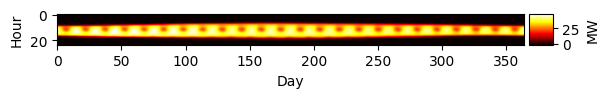

Text(0.5, 1.0, 'Power output of a Solar tower  throughout a year [Mw]')

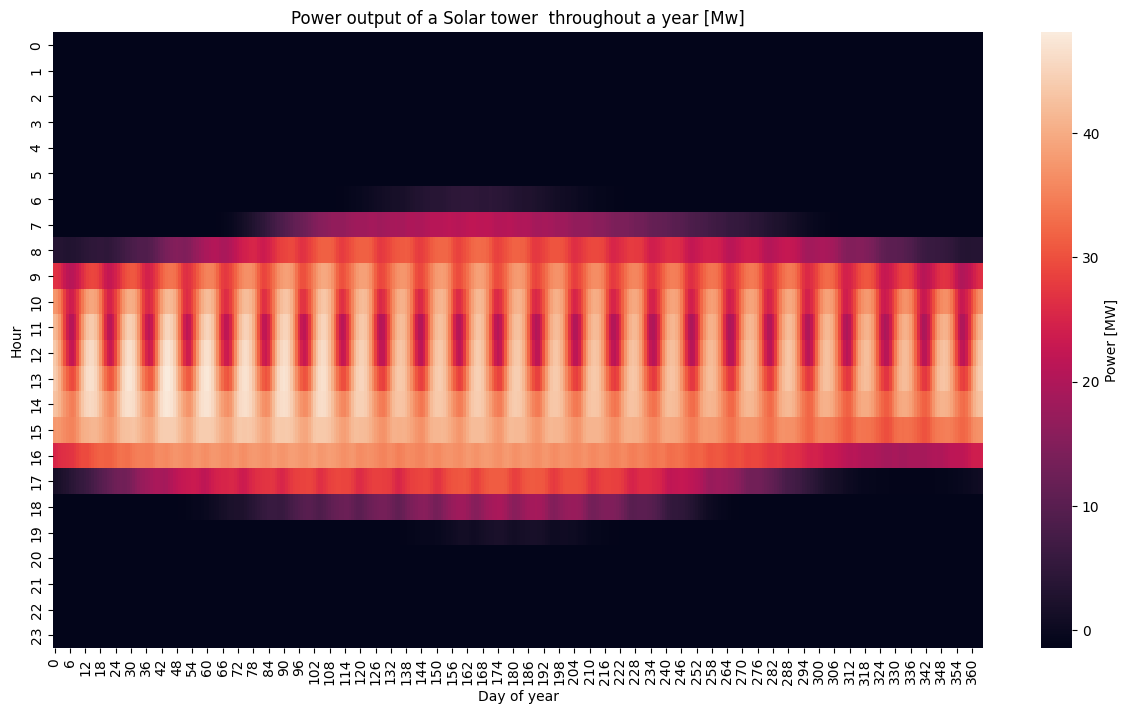

In [7]:
oTow = stCrete.perform_calc(Ib=Ib_pvgis, transmittance=1, nG=0.97)

cspmisc.heatmap2d(oTow.data4surf().T)
cspmisc.heatmap2d_sns(oTow.data4surf().T)
plt.title('Power output of a Solar tower  throughout a year [Mw]')

## 3.2 Solar Trough calculations

A solar trough calculations object can be described as.

The following defines a Solar trough with the following characteristics:
- focal length of 0.88  [m] focal length CSPP
- Number of units N = 1800 # [m * troughs] 25 * 48 
- Length of units L = 25 # [m * troughs] 12 * 40 
- collector spacing between rows  [m] Ws = 18  
- corrector  tube outer diameter [m] Wr = 0.07 
- corrector  collector outer diameter [m] Wc = 5.76

In [8]:
stroCrete =  SolarTroughCalcs(
        foc_len = 0.88 # [m] focal length CSPP T.1 in Mosleh19
        ,N = 1800 # [m * troughs] 25 * 48 CSPP pp.4 in Mosleh19 for 250 kWe turbine
        ,L = 25 # [m * troughs] 12 * 40 DISS pp.3 in Zarza04 for 70MWe turbine  
        ,Ws = 18 # [m] width between rows 18 INDITEP in pp.6 Fraidenraich13, pp.5 Zarza06
        ,Wr = 0.07 # tube outer diameter [m]
        ,Wc = 5.76,
        slobj= sslCrete
        )


Text(0.5, 1.0, 'Power output of a Solar Trough EW   throughout a year [Mw]')

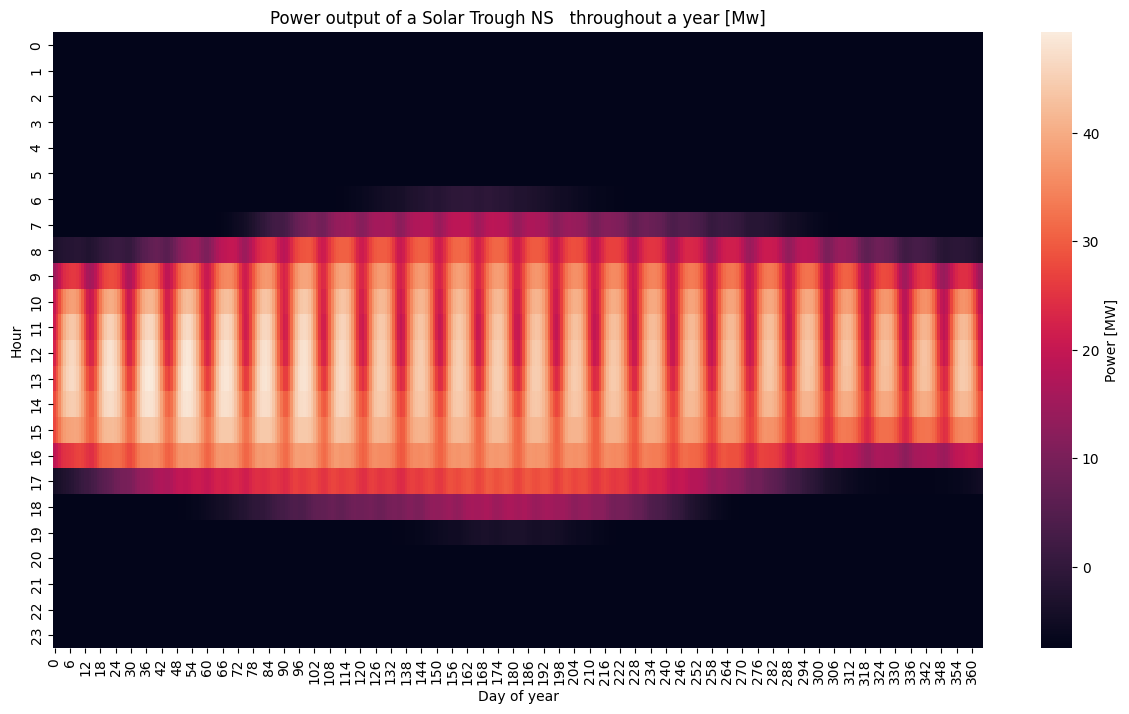

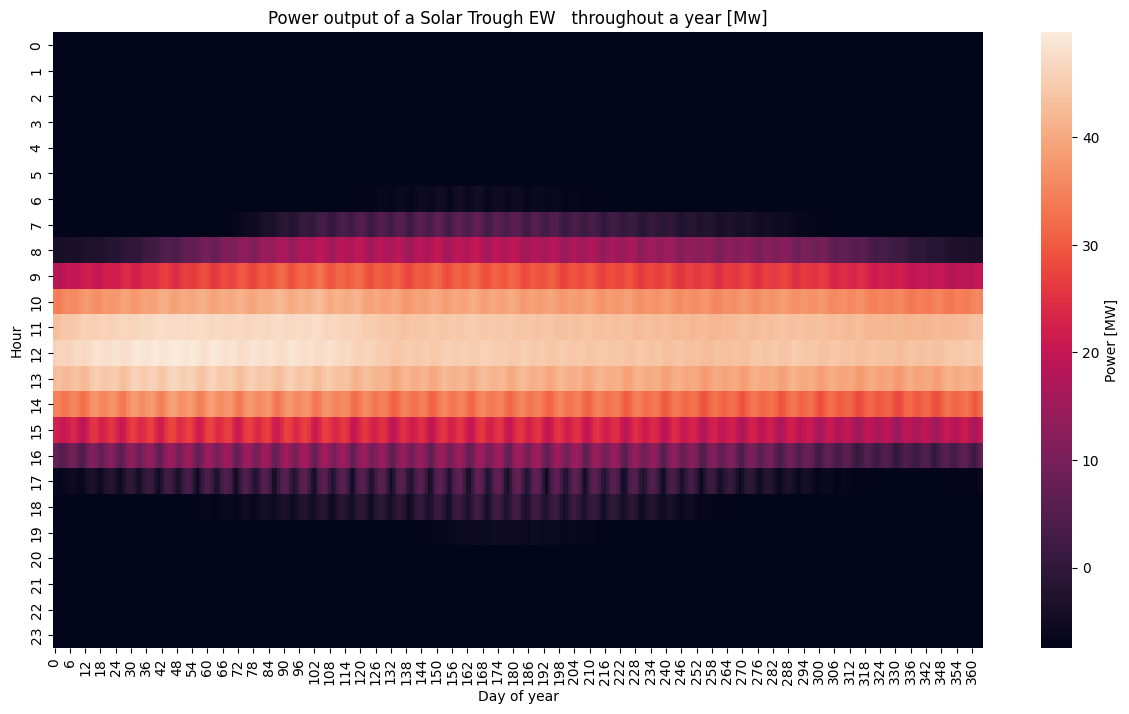

In [9]:
otrNS = stroCrete.perform_calcs_NS(Ib=Ib_pvgis, Tr=318)
otrEW = stroCrete.perform_calcs_EW(Ib=Ib_pvgis, Tr=318)

cspmisc.heatmap2d_sns(otrNS.data4surf().T)
plt.title('Power output of a Solar Trough NS   throughout a year [Mw]')
cspmisc.heatmap2d_sns(otrEW.data4surf().T)
plt.title('Power output of a Solar Trough EW   throughout a year [Mw]')

## comparison between Solar Tower and Trough EW, NS

In order to compare the performance between the trough with EW, NS alignments and the tower performance, the `compare_date` function can be used. 

Total incident energy of NS Solar Trough =2044098.98 [MWh]
Total incident energy of NS Solar Trough =1822865.26 [MWh]


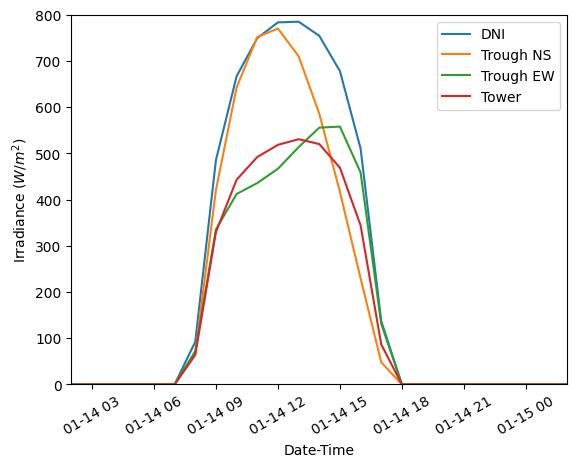

In [10]:
compare_date('2020-01-14', trough=stroCrete, tower=stCrete, Ib= Ib_pvgis, save_to_file=True)

Data From  in August 26th

Total incident energy of NS Solar Trough =2044098.98 [MWh]
Total incident energy of NS Solar Trough =1822865.26 [MWh]


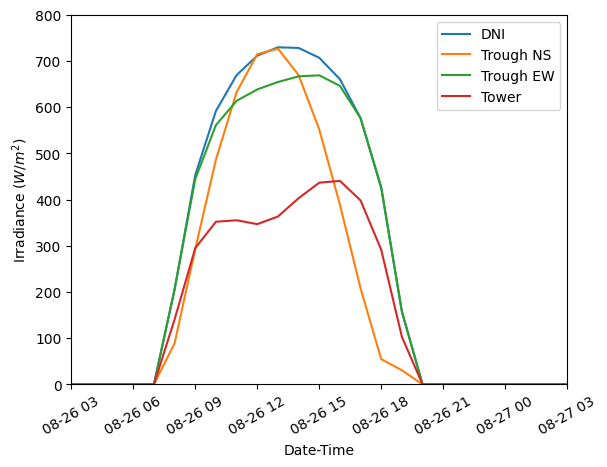

In [11]:
compare_date('2020-08-26', trough=stroCrete, tower=stCrete, Ib=Ib_pvgis, save_to_file=True)

## . Economic Analysis

In [12]:
ee = Economic_environment(   
            oil_price=60, 
            Eoil=11.766,
            currency_units='USD')


# miscellaneous 

The following plots data from ?? efficiency 

In [13]:

# # def heatmap2d(arr: np.ndarray):
# #     plt.imshow(arr, cmap='viridis')
# #     plt.colorbar()
# #     plt.show()

# heatmap2d(tow_xyz.T)
# heatmap2d(tro_xyz.T)
# heatmap2d(combiNS_xyz.T)
# heatmap2d(combiEW_xyz.T)

In [14]:
# index = ['Total aperture area $(m^2)$',
#          'Geometrical concentration',
#          'Power (MW)',
#          'Annual energy (MWh)',
#          'Capacity factor',
#          'DPB',
#          'NPV',
#          'IRR',
#          'Cash flows']
# tow_scenaria = pd.DataFrame(np.transpose(tow_scenaria), index=index).round(2)
# #np.savetxt(r'C:\Users\gearn\+MyScripts\Solar\tables\tow.txt', tow_scenaria.iloc[:8].values, fmt='%d')
# tow_scenaria.iloc[:8].to_csv('tow.csv')
# tow_scenaria.iloc[:8]

In [15]:
# trough_scenaria = pd.DataFrame(np.transpose(trough_scenaria), index=index).round(2)
# trough_scenaria.iloc[:8]

In [16]:
# troughew_scenaria = pd.DataFrame(np.transpose(troughew_scenaria), index=index).round(2)
# troughew_scenaria.iloc[:8]

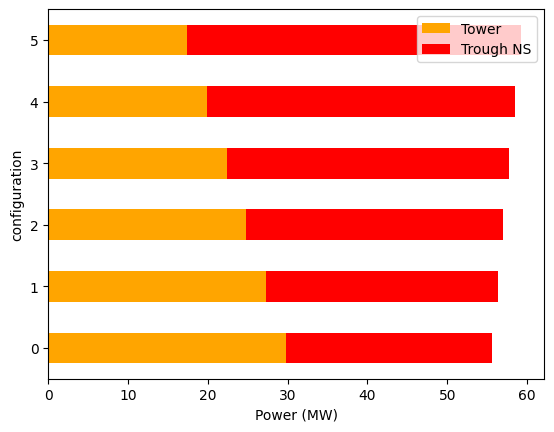

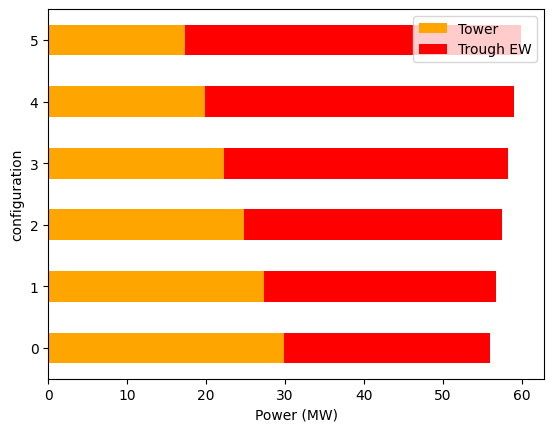

In [17]:
tow = [17.3385,19.8417,22.3449,24.8481,27.3512,29.8544]
trons = [41.8438,38.6251,35.4063,32.1876,28.9688,25.7501]
troew = [42.5302,39.2586,35.9871,32.7155,29.444,26.1724]
index = ['Tower','Trough NS']
df = pd.DataFrame({'Tower':tow[::-1],'Trough NS':trons[::-1]})
ax = df.plot.barh(stacked=True, color = ('orange','r'))
plt.ylabel('configuration')
plt.xlabel('Power (MW)')
plt.savefig(IMG_FOLDER /'Fig4a.png')

df2 = pd.DataFrame({'Tower':tow[::-1],'Trough EW':troew[::-1]})
ax = df2.plot.barh(stacked=True, color = ('orange','r'))
plt.ylabel('configuration')
plt.xlabel('Power (MW)')
plt.savefig(IMG_FOLDER  /'Fig4b.png')